# Evaluation of the RandomForest model

## Import libraries

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from scivision.io import load_pretrained_model, load_dataset

## Load datasets

### load holdout images

In [4]:
cat = load_dataset('https://github.com/alan-turing-institute/plankton-dsg-challenge')

ds_all = cat.plankton_multiple().to_dask()
labels_holdout = cat.labels_holdout().read()

labels_holdout_dedup = xr.Dataset.from_dataframe(
    labels_holdout
    .drop_duplicates(subset=["filename"])
    .set_index("filename")
    .sort_index()
)

ds_holdout_labelled = (
    ds_all
    .swap_dims({"concat_dim": "filename"})
    .merge(labels_holdout_dedup, join="inner")
    .swap_dims({"filename": "concat_dim"})
)

In [6]:
ds_holdout_labelled

<xarray.Dataset>
Dimensions:                               (channel: 3, concat_dim: 5682, x: 1040, y: 832)
Coordinates:
    filename                              (concat_dim) object 'Pia1.2016-10-0...
  * concat_dim                            (concat_dim) int64 18 56 ... 58732
  * y                                     (y) int64 0 1 2 3 ... 828 829 830 831
  * x                                     (x) int64 0 1 2 3 ... 1037 1038 1039
  * channel                               (channel) int64 0 1 2
Data variables: (12/27)
    raster                                (concat_dim, y, x, channel) uint8 dask.array<chunksize=(1, 832, 1040, 3), meta=np.ndarray>
    EXIF Image ImageWidth                 (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image ImageLength                (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image BitsPerSample              (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image Compression                (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image PhotometricInterpretation  (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    ...                                    ...
    EXIF GPS GPSLongitude                 (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    EXIF Image GPSInfo                    (concat_dim) object dask.array<chunksize=(1,), meta=np.ndarray>
    index                                 (concat_dim) int64 12066 ... 58780
    label1                                (concat_dim) object 'zooplankton' ....
    label2                                (concat_dim) object 'noncopepod' .....
    label3                                (concat_dim) object 'copepod_naupli...

In [5]:
type(ds_holdout_labelled)

xarray.core.dataset.Dataset

In [7]:
# choose a test image
image_no = 65
image = ds_holdout_labelled['raster'].sel(concat_dim=image_no).compute().values
label_gt = ds_holdout_labelled['label3'].sel(concat_dim=image_no).compute().values

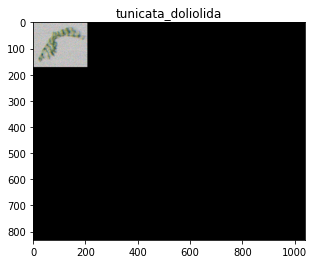

In [8]:
plt.figure()
plt.imshow(image)
plt.title("{}".format(label_gt))
plt.show()

### Load features matrix

In [9]:
cat = load_dataset('/output/plankton_features.yaml')

In [10]:
list(cat)

['labelled_features_test']

In [11]:
input_df = cat.labelled_features_test.read()

In [13]:
print(input_df.shape)

(5682, 40)


In [12]:
input_df.head()

,index,filename,label1,label2,label3,object_label,object_width,object_height,object_bx,object_by,...,object_bounding_box_area,object_eccentricity,object_equivalent_diameter,object_euler_number,object_extent,object_local_centroid_col,object_local_centroid_row,object_solidity,img_file_name,img_rank
0,68,Pia1.2017-10-08.1928+N00146994_hc.tif,zooplankton,noncopepod,annelida_polychaeta,1,96,110,0,0,...,10560,0.488228,115.954343,1,1.0,47.5,54.5,1.0,0-Pia1.2017-10-08.1928+N00146994_hc-1.tif,1
1,129,Pia1.2019-10-15.0706+N00297493_hc.tif,zooplankton,noncopepod,annelida_polychaeta,1,104,78,0,0,...,8112,0.661468,101.629322,1,1.0,51.5,38.5,1.0,0-Pia1.2019-10-15.0706+N00297493_hc-1.tif,1
2,43,Pia1.2017-10-03.1726+N00002415_hc.tif,zooplankton,noncopepod,annelida_polychaeta,1,96,84,0,0,...,8064,0.484149,101.328198,1,1.0,47.5,41.5,1.0,0-Pia1.2017-10-03.1726+N00002415_hc-1.tif,1
3,14,Pia1.2017-03-25.0240+N00408867_hc.tif,zooplankton,noncopepod,annelida_polychaeta,1,88,84,0,0,...,7392,0.298085,97.014363,1,1.0,43.5,41.5,1.0,0-Pia1.2017-03-25.0240+N00408867_hc-1.tif,1
4,51,Pia1.2017-10-03.1726+N00273214_hc.tif,zooplankton,noncopepod,annelida_polychaeta,1,104,86,0,0,...,8944,0.562341,106.713891,1,1.0,51.5,42.5,1.0,0-Pia1.2017-10-03.1726+N00273214_hc-1.tif,1


## Load pretrained model

In [4]:
#!pip -q uninstall -y scivision_plankton_models only run if changes are made in https://github.com/acocac/scivision-plankton-models

In [14]:
# Load model
scivision_yml = 'https://github.com/acocac/scivision-plankton-models/.scivision-config.yaml'
model = load_pretrained_model(scivision_yml, allow_install=True)

In [15]:
model

scivision.PretrainedModel( 
  module='scivision_plankton_models', 
  model='randomforest', 
  source='https://github.com/acocac/scivision-plankton-models' 
  pipe='DataPipe(input=<Parameter "X: numpy.ndarray">, output=<Parameter "image: numpy.ndarray">)' 
)

## Preprocess image

In [16]:
cols_retain = [col for col in input_df.columns if col not in ['index', 'img_file_name', 'filename','filename.1', 'label1', 'label2', 'label3']]

In [17]:
X_test = input_df[cols_retain] 

In [18]:
x_input = X_test.to_numpy()

In [19]:
x_input.shape

(5682, 34)

In [69]:
# Get model predicition of image
preds = model.predict(x_input)

In [70]:
preds

array([14, 14, 21, ...,  9, 13, 37])

In [83]:
#query a given filename from the ds_holdout_labelled xarray.Dataset object
index_target = 50
fn_target = input_df.iloc[index_target].filename
index_xarray = ds_holdout_labelled.concat_dim[ds_holdout_labelled.filename == fn_target].values[0]

In [84]:
image = ds_holdout_labelled['raster'].sel(concat_dim=index_xarray).compute().values
label_gt = ds_holdout_labelled['label3'].sel(concat_dim=index_xarray).compute().values

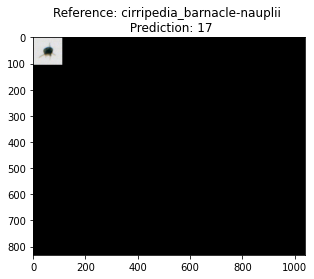

In [85]:
plt.figure()
plt.imshow(image)
plt.title("Reference: {} \n Prediction: {}".format(label_gt, preds[index_target]))
plt.show()